In [3]:
library("brms")
library("dplyr")
library("bayesplot")
library("rstanarm")
library("ggplot2")
library("rstan")
library("tidyr")
library("ggpubr")
library("projpred")
library("corrplot")
library("loo")
library("tidyverse")
library("here")
library("knitr")
library("walker")
library("tidybayes")
library("broom")
library("ggridges")
library("reshape2")
library("lubridate")
library("hrbrthemes")
library("viridis")
library('ggthemes')
library(scales)
options(repr.plot.width=10, repr.plot.height=10)

This model is based on data taken from Figure 3 
https://reader.elsevier.com/reader/sd/pii/S0167577X20315433?token=661728B0466FC76D2003CC4F6314E8EEC5DB8C7E6BE4B1B7983DC00392689F48C68839CEBD1E35A55AC0B5936308FA1F
showing measurements for shear strength and surface roughness for silica cold joined with an instoatic pressure of 300 MPa, and with no pressure applied.

[1] 1.354006

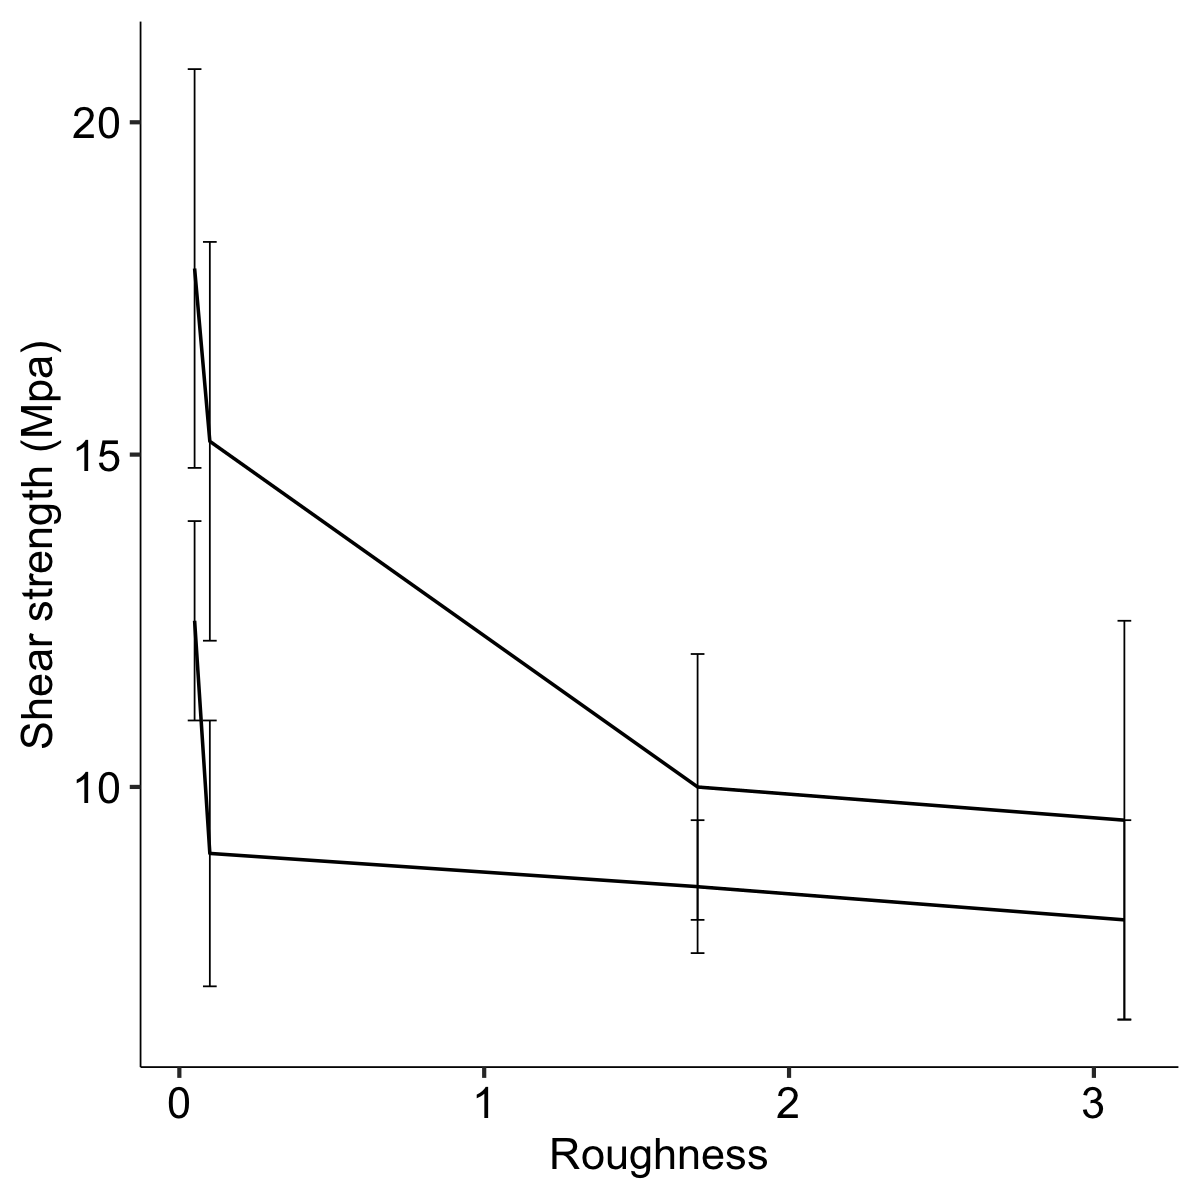

In [4]:
#Guessing the data from the figure and replotting
df1=data.frame("roughness" = c(0.05,0.1,1.7,3.1),
              "shearStrength"=c(17.8,15.2,10,9.5),
              "shearStrengthU"=c(17.8+3,15.2+3,10+2,9.5+3),
              "shearStrengthL"=c(17.8-3,15.2-3,10-2,9.5-3),
              "pressure"=c(0,0,0,0)
          )
df2=data.frame("roughness" = c(0.05,0.1,1.7,3.1),
              "shearStrength"=c(12.5,9,8.5,8),
              "shearStrengthU"=c(12.5+1.5,9+2,8.5+1,8+1.5),
              "shearStrengthL"=c(12.5-1.5,9-2,8.5-1,8-1.5),
              "pressure"=c(300,300,300,300)
          )
df = rbind(df1,df2)

sqrt(mean((df1$shearStrengthU - df1$shearStrengthL) + (df1$shearStrengthU - df1$shearStrengthL))/6)

ggplot(data=df) + geom_line(aes(x=roughness,y=shearStrength,group=pressure),size=1)+
    geom_errorbar(aes(x=roughness, ymin=shearStrengthL, ymax=shearStrengthU))+
    xlab("Roughness")+ ylab("Shear strength (Mpa)")+
    theme_pubr(26)

### Fit nonlinear model to data

Form of the model is shear strength is an offset log linear, with coefficients expanded in pressure:

\tau(r,p)=\alpha_{0}+\alpha_{0}^{'}p+\alpha_{0}^{''}pr+\text{exp}\left(\alpha_{1}+\left(\alpha_{2}+\alpha_{2}^{'}p\right)\,r\right)

Compiling Stan program...

Start sampling



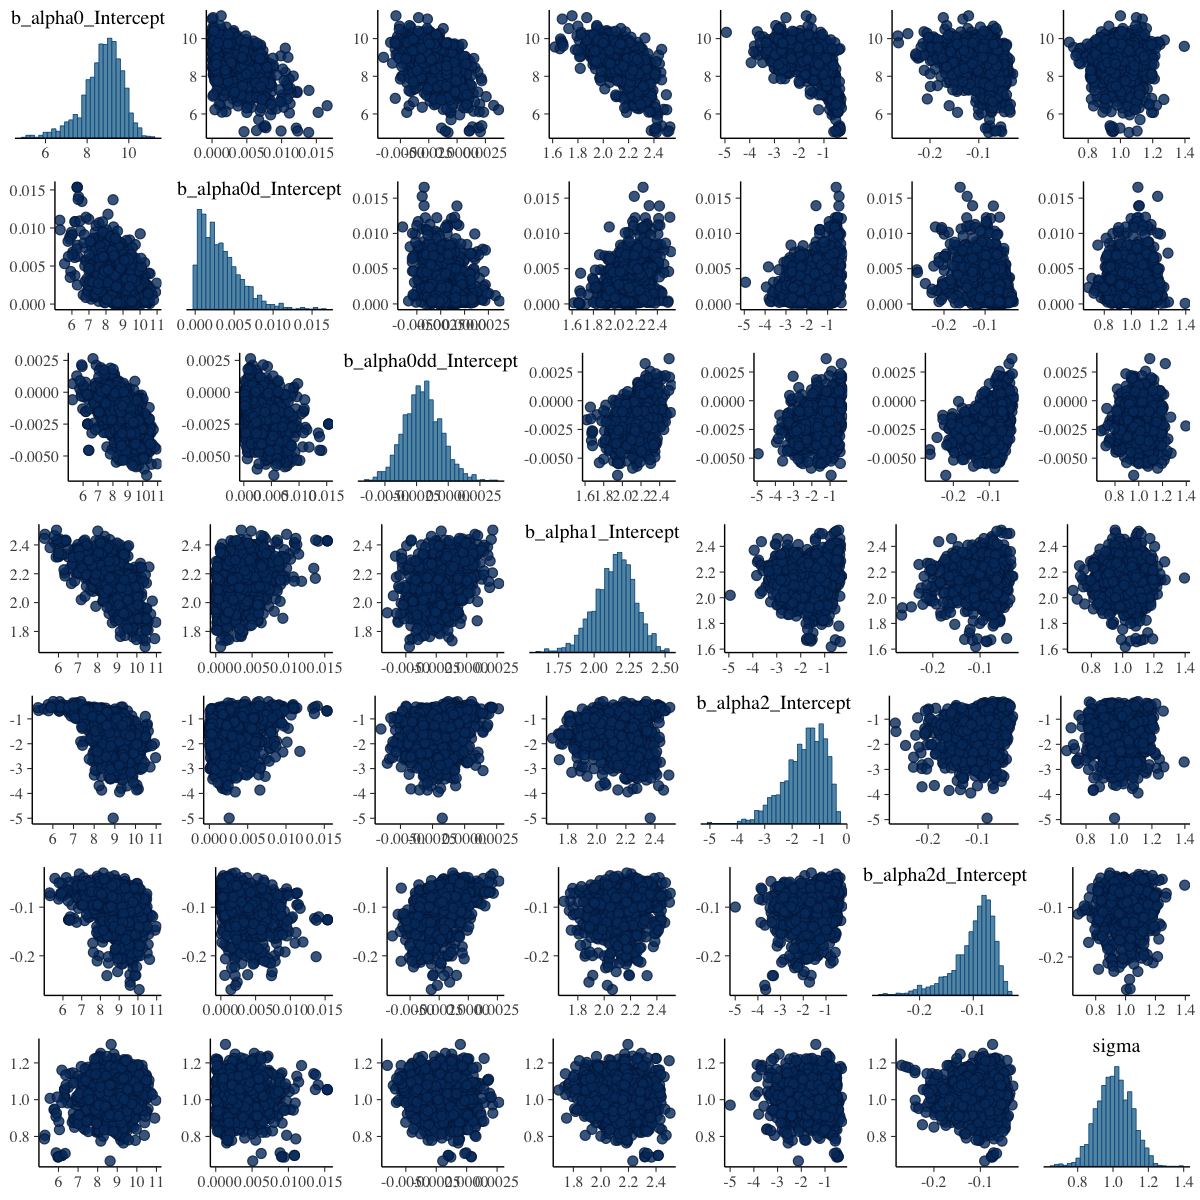

In [11]:
prior1 <- prior(normal(1, 0.1), class = "sigma") +
          prior(normal(10, 3), nlpar = "alpha0", lb=0) +
          prior(normal(0, 0.1), nlpar = "alpha0d", lb=0) +
          prior(normal(0, 0.1), nlpar = "alpha0dd") +
          prior(normal(2, 2), nlpar = "alpha1") +
#           prior(normal(0, 0.1), nlpar = "alpha1d") +
          prior(normal(-1, 1), nlpar = "alpha2",ub=0) +
            prior(normal(0, 0.1), nlpar = "alpha2d") 
fit <- brm(
        bf(shearStrength ~ ((alpha0 + alpha0d * pressure+ alpha0dd * pressure * roughness) + 
                            exp( (alpha1) + 
                            (alpha2 + alpha2d * pressure) * pow(roughness,1))),
        alpha0 + alpha0d + alpha0dd + alpha1 + alpha2 + alpha2d ~ 1, 
        nl = TRUE),
        data = df, 
        prior=prior1,
        iter=2000,
        chains = 2,
        cores = 2,
        seed = 8888,
        control = list(adapt_delta = 0.9),
        refresh = 0
)
pairs(fit)



Exmaine the parameters sampled

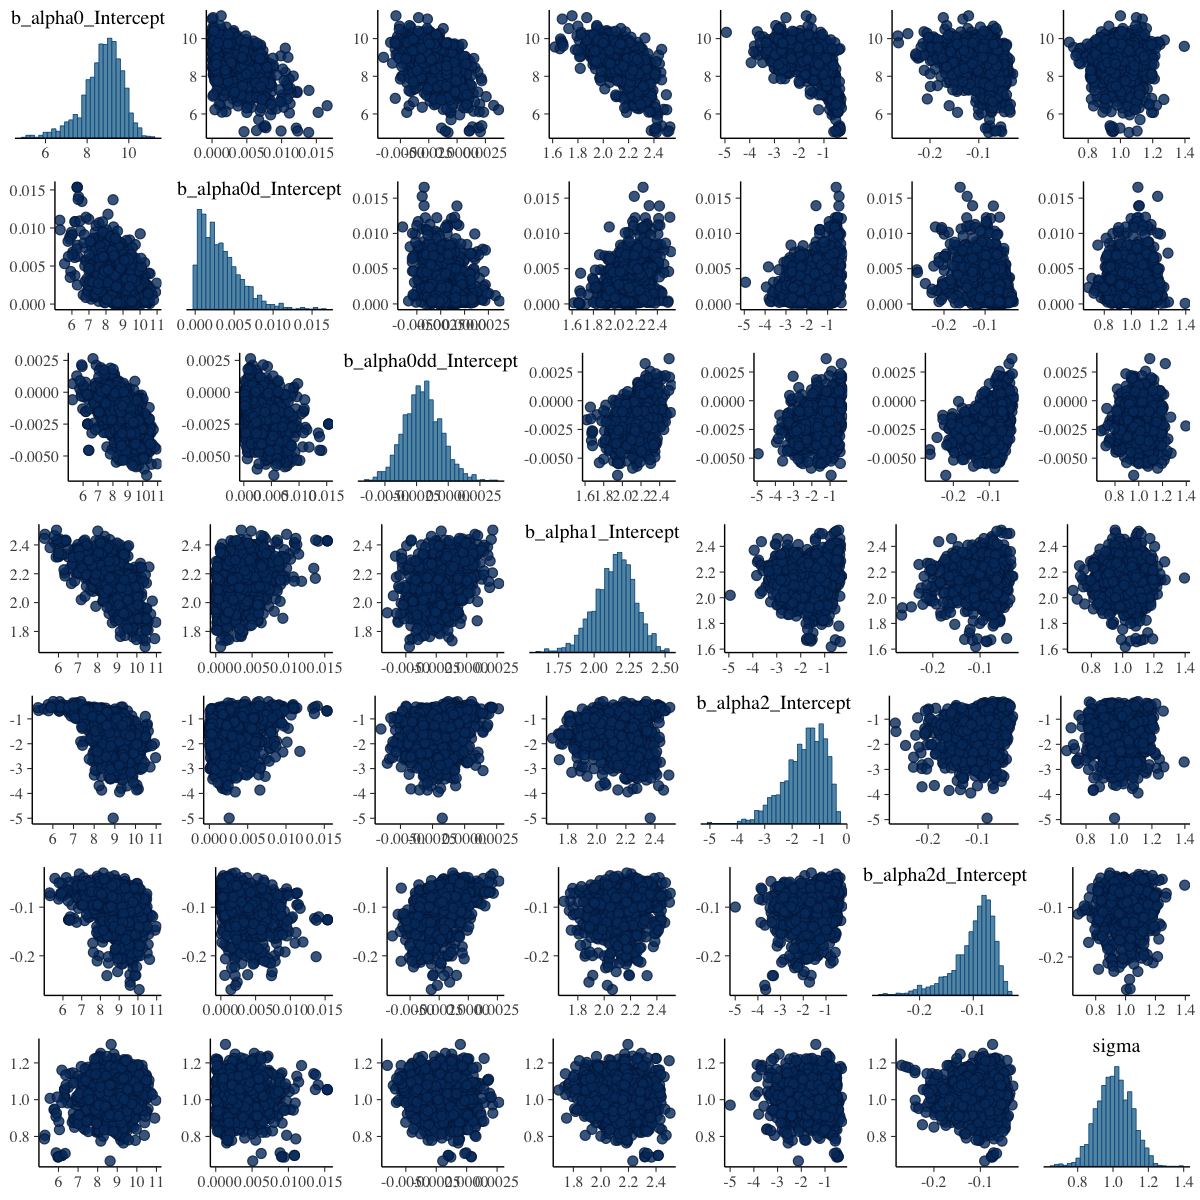

In [12]:
pairs(fit)
# preds=cbind(predict(fit,newdata=df),df)
# preds
# ggplot(data=preds) + geom_line(aes(x=roughness,y=shearStrength,group=pressure),size=1)+
#     geom_errorbar(aes(x=roughness, ymin=shearStrengthL, ymax=shearStrengthU))+
#     xlab("Roughness")+ ylab("Shear strength (Mpa)")+
#     theme_pubr(26) +
#     geom_line(aes(x=roughness, y=Estimate,group=pressure),col="Green")

Plot model fit

In [13]:
pred_df1 = data.frame(roughness=seq(0.00,5,0.05),pressure=rep(0,length(seq(0.00,5,0.05))))
preds1 = cbind(pred_df1,predict(fit,newdata=pred_df1,probs=c(0.05,0.125,0.25,0.375,0.675,0.75,0.875,0.95)))
preds1$key = "0Pa"

pred_df2 = data.frame(roughness=seq(0.00,5,0.05),pressure=rep(300,length(seq(0.00,5,0.05))))
preds2 = cbind(pred_df2,predict(fit,newdata=pred_df2,probs=c(0.05,0.125,0.25,0.375,0.675,0.75,0.875,0.95)))
preds2$key = "300Pa"

preds = rbind(preds1,preds2)

head(preds)
tail(preds)

,roughness,pressure,Estimate,Est.Error,Q5,Q12.5,Q25,Q37.5,Q67.5,Q75,Q87.5,Q95,key
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.00,0,17.38381,1.375386,15.27101,15.89419,16.47784,16.91622,17.93710,18.24639,18.99437,19.72306,0Pa
2,0.05,0,16.74165,1.266311,14.66954,15.23429,15.89050,16.37409,17.31002,17.57326,18.14954,18.87183,0Pa
3,0.10,0,16.17817,1.208221,14.15020,14.74594,15.37620,15.81465,16.75663,17.01865,17.54722,18.11263,0Pa
4,0.15,0,15.65333,1.211920,13.73376,14.27554,14.85317,15.24668,16.19502,16.44125,17.06279,17.69700,0Pa
5,0.20,0,15.19847,1.279590,13.04593,13.73165,14.34678,14.80306,15.78046,16.08013,16.66236,17.27982,0Pa
6,0.25,0,14.72560,1.298043,12.50647,13.18662,13.86219,14.29671,15.35778,15.64384,16.17094,16.80172,0Pa


,roughness,pressure,Estimate,Est.Error,Q5,Q12.5,Q25,Q37.5,Q67.5,Q75,Q87.5,Q95,key
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
197,4.75,300,6.845495,1.824653,3.862418,4.767687,5.545543,6.286028,7.678071,8.080266,8.953082,9.861805,300Pa
198,4.80,300,6.850356,1.856151,3.829854,4.709034,5.592348,6.307313,7.722233,8.127640,8.963213,9.939368,300Pa
199,4.85,300,6.808520,1.884849,3.706084,4.649847,5.524153,6.207927,7.634468,8.082290,8.969169,9.911765,300Pa
200,4.90,300,6.715669,1.895349,3.592491,4.529564,5.462295,6.114445,7.566709,7.995068,8.940334,9.829287,300Pa
201,4.95,300,6.719050,1.902255,3.600728,4.584483,5.449669,6.084674,7.557840,7.981248,8.881505,9.854182,300Pa
202,5.00,300,6.683787,1.919805,3.482934,4.436750,5.385887,6.102068,7.550453,7.962282,8.819599,9.728548,300Pa


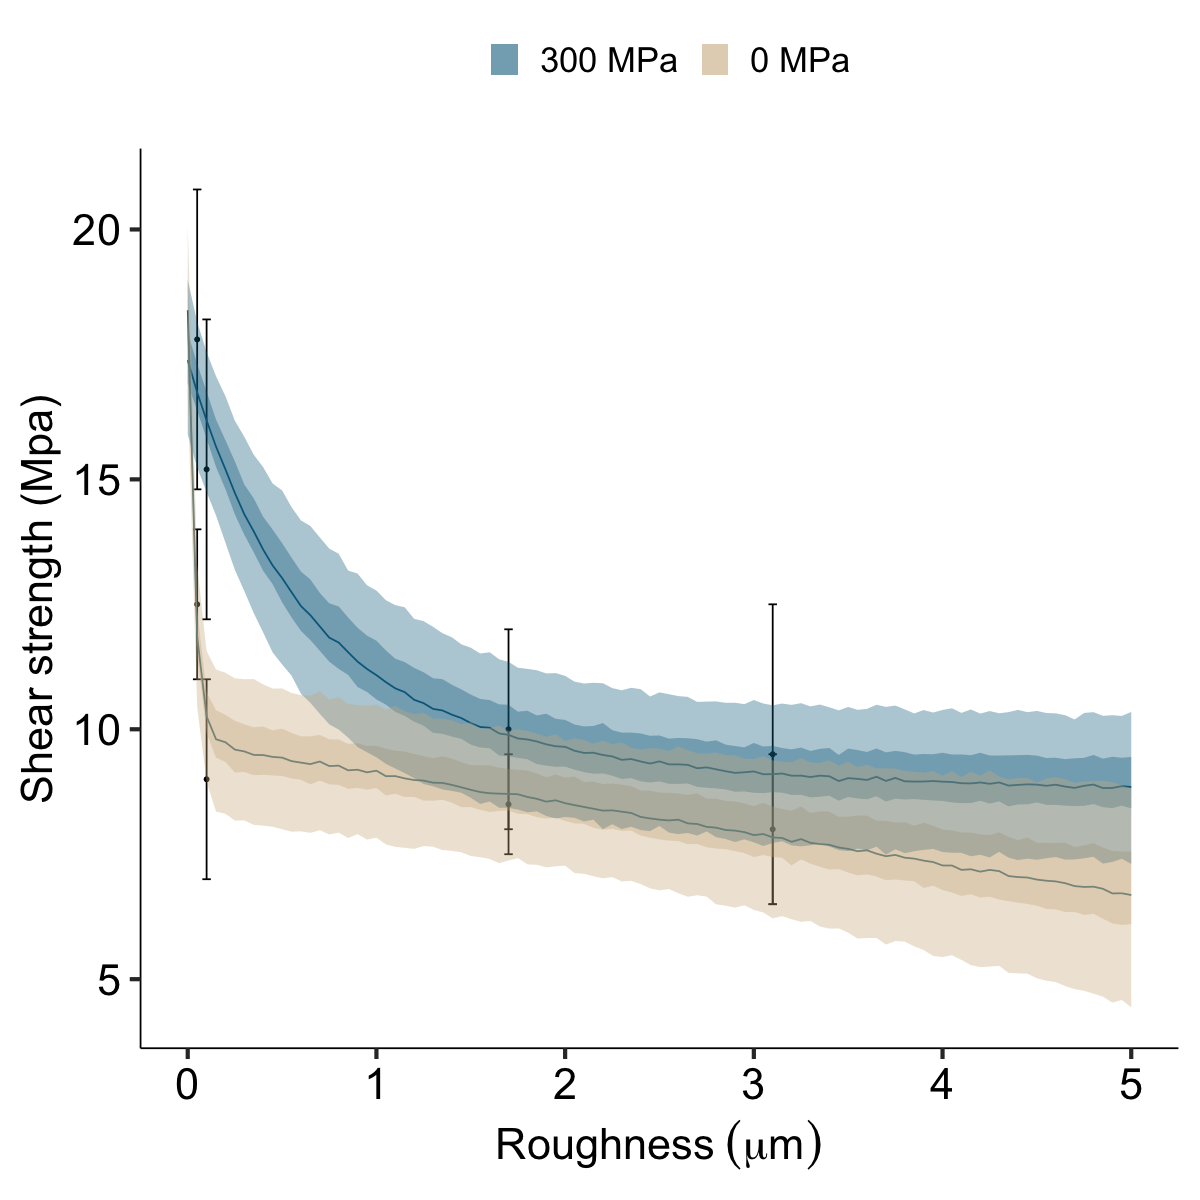

In [18]:
ggplot(data=df) + geom_point(aes(x=roughness,y=shearStrength,group=pressure),size=1)+
    geom_errorbar(aes(x=roughness, ymin=shearStrengthL, ymax=shearStrengthU))+
    xlab(expression(Roughness ~ (mu*m)))+ ylab("Shear strength (Mpa)")+
    theme_pubr(26) +
    geom_line(data = preds , aes(x=roughness, y=Estimate,group=pressure),col="Deepskyblue4") + 
    geom_ribbon(data = preds, aes(x = roughness, ymin = Q37.5, ymax = Q67.5, fill = key)) +
#     geom_ribbon(data = preds, aes(x = roughness, ymin = Q5, ymax = Q95, fill = key)) +
    geom_ribbon(data = preds, aes(x = roughness, ymin = Q12.5, ymax = Q87.5, fill = key)) +
#     geom_ribbon(data = preds, aes(x = roughness, ymin = Q5, ymax = Q95, fill = key)) +
     scale_fill_manual(name = "", labels = c("300 MPa","0 MPa"),values = c(alpha("Deepskyblue4",0.35),
                                                                     alpha("Tan",0.35)))

In [20]:
basis = data.frame(roughness=seq(0.00,5,0.05),pressure=seq(0,300,3))
expanded_pred_df = basis %>% expand(roughness,pressure)
preds2 = cbind(expanded_pred_df,predict(fit,newdata=expanded_pred_df,probs=c(0.05,0.25,0.75,0.95)))
colnames(preds2)[3] <- "Shear Strength MPa"
head(preds2)

,roughness,pressure,Shear Strength MPa,Est.Error,Q5,Q25,Q75,Q95
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,17.37192,1.371211,15.21256,16.41659,18.30483,19.64291
2,0,3,17.37401,1.398230,15.05240,16.41067,18.32300,19.59904
3,0,6,17.42438,1.357414,15.22569,16.51166,18.31353,19.71064
4,0,9,17.39325,1.359905,15.16125,16.50248,18.26600,19.66509
5,0,12,17.41947,1.382445,15.18093,16.51693,18.30127,19.73071
6,0,15,17.41883,1.323487,15.31594,16.54833,18.27445,19.62176


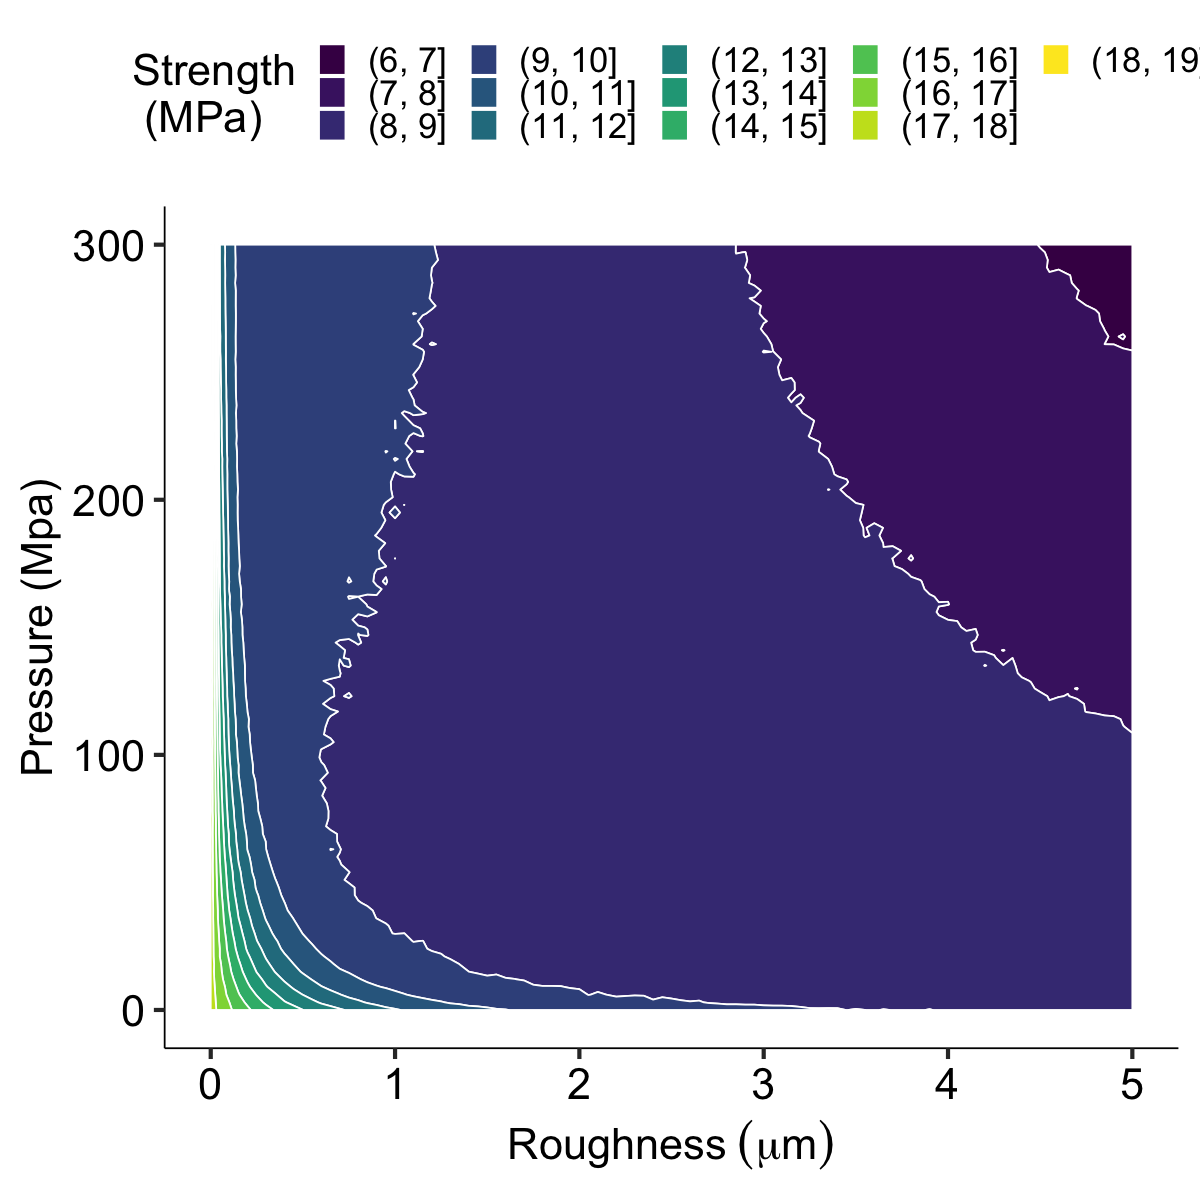

In [21]:
ggplot(data = preds2) +
    geom_contour_filled(aes(x=roughness, y=pressure, z=`Shear Strength MPa`),colour = "white") + 
    xlab(expression(Roughness ~ (mu*m)))+ ylab("Pressure (Mpa)")+
    guides(fill=guide_legend(title="Strength\n (MPa)"))+
#     scale_fill_(name=`Shear Strength MPa`) +
#     scale_fill_discrete(name = `Shear Strength MPa`)+
    theme_pubr(26) 